In [ ]:
from google.colab import drive
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import cv2
from collections import defaultdict
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

from torchvision import datasets, transforms, models
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive and extract data
drive.mount('/content/drive')
!unzip -q "/content/drive/MyDrive/archive (3).zip" -d ./underwater_animals
!ls ./underwater_animals


Mounted at /content/drive
 Clams	   Fish		 Otter	   'Sea Rays'	   Starfish
 Corals   'Jelly Fish'	 Penguin   'Sea Urchins'   Turtle_Tortoise
 Crabs	   Lobster	 Puffers    Sharks	   Whale
 Dolphin   Nudibranchs	 Seahorse   Shrimp
 Eel	   Octopus	 Seal	    Squid


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
#Enhanced data splitting with stratified sampling
def stratified_split(source_dir, target_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Perform stratified sampling to ensure balanced class distribution across splits"""

    # Create target directories
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(target_dir, split)
        if not os.path.exists(split_path):
            os.makedirs(split_path)

    # Process each class
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train+n_val],
            'test': images[n_train+n_val:]
        }

        # Copy files to respective directories
        for split, files in splits.items():
            split_class_dir = os.path.join(target_dir, split, class_name)
            if not os.path.exists(split_class_dir):
                os.makedirs(split_class_dir)

            for f in files:
                src = os.path.join(class_path, f)
                dst = os.path.join(split_class_dir, f)
                shutil.copy(src, dst)

    print("Stratified data split complete!")

# Perform data splitting
source_dir = './underwater_animals'
target_dir = './dataset_split'
stratified_split(source_dir, target_dir)

Stratified data split complete!


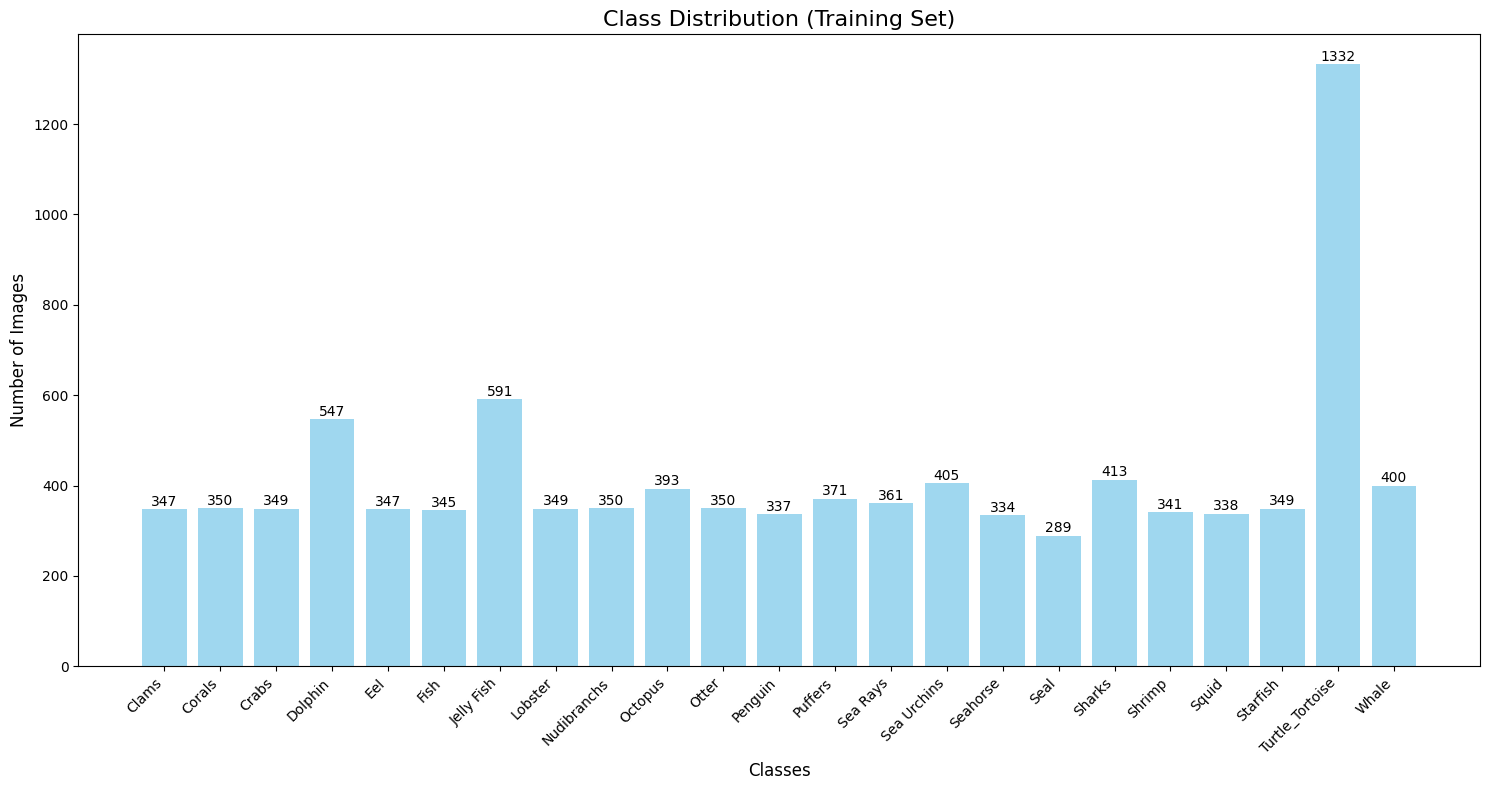

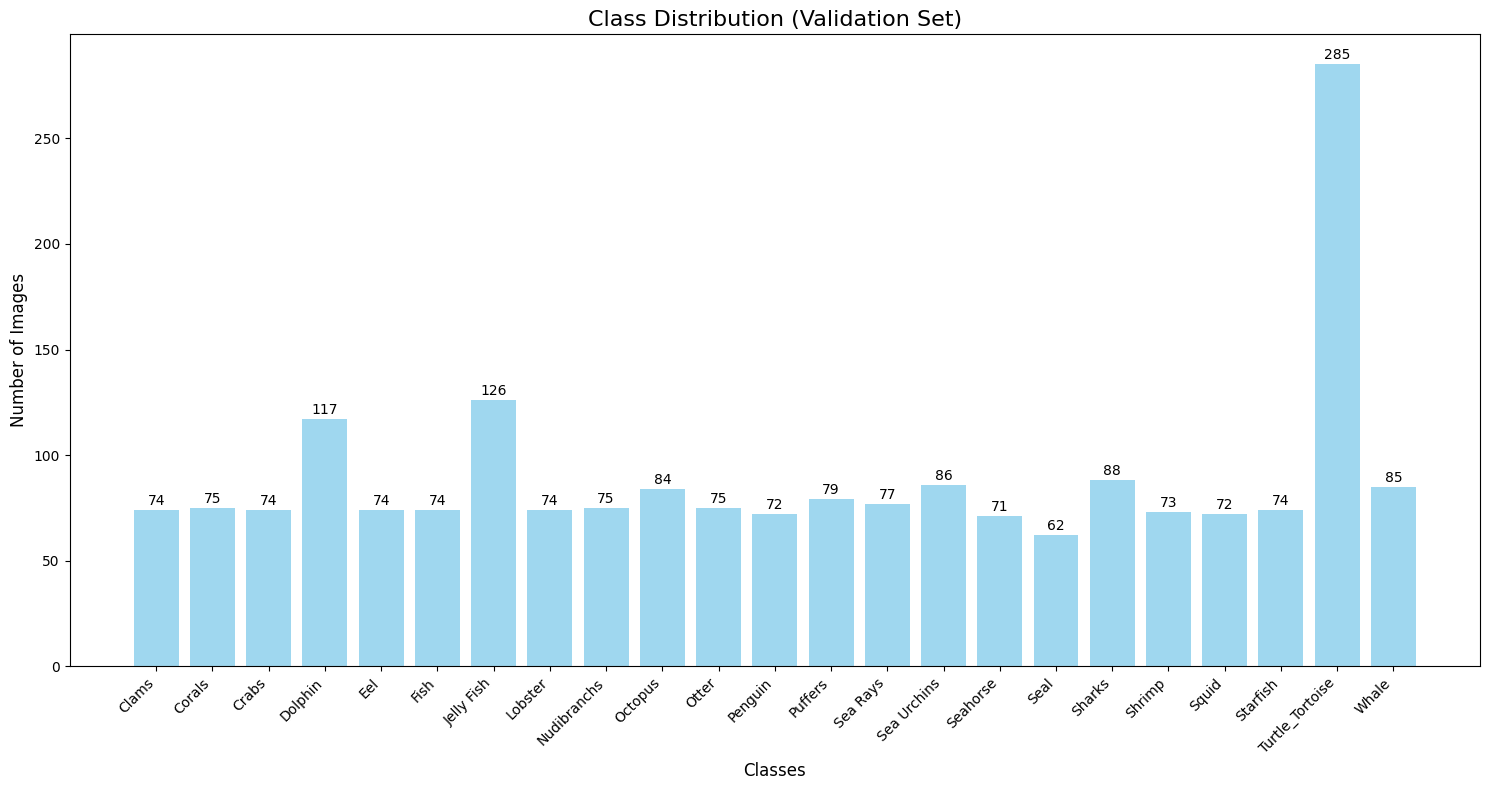

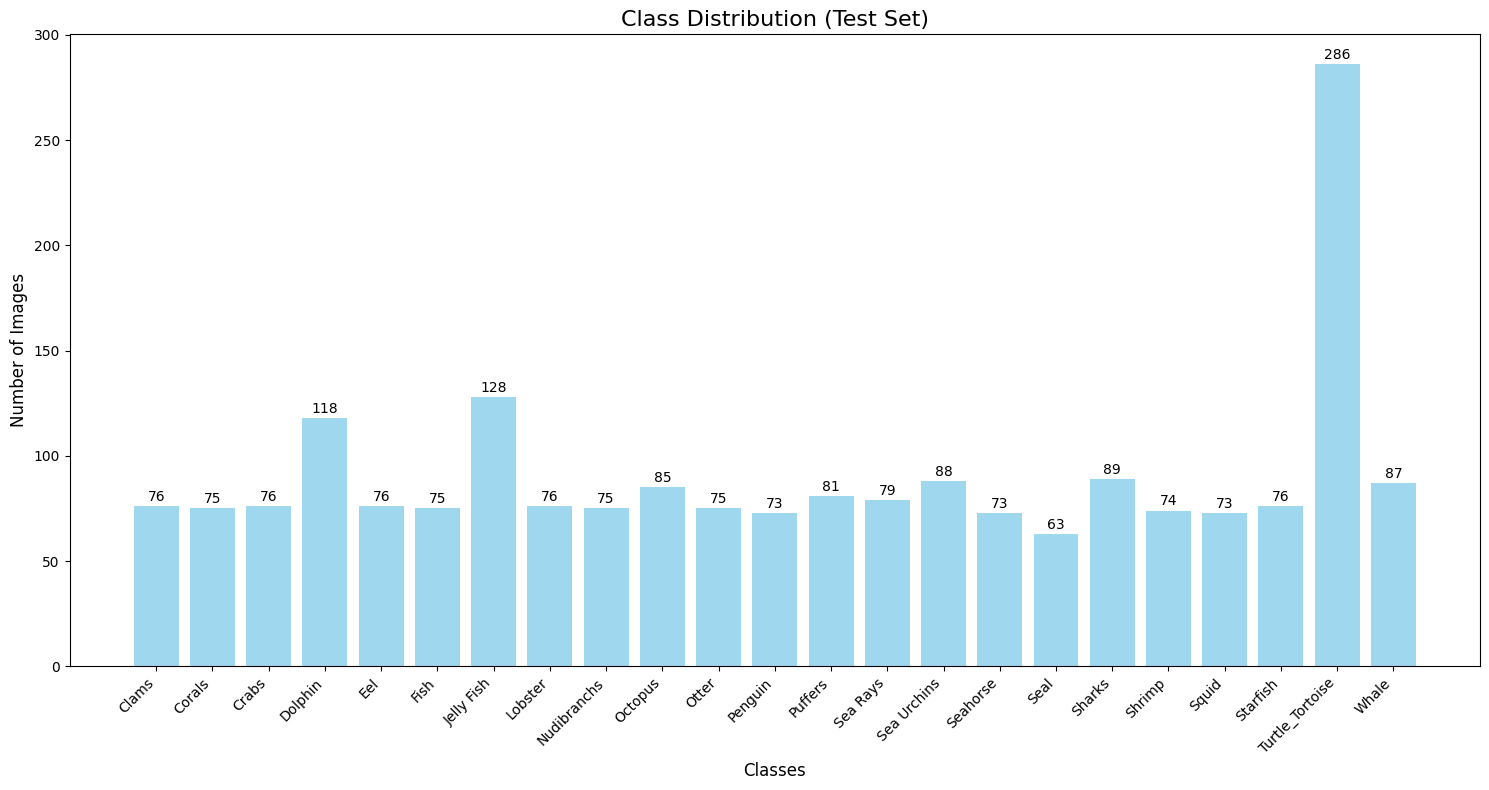

In [ ]:
# Visualization functions
def plot_class_distribution(path, title_suffix=""):
    """Plot class distribution with enhanced visualization"""
    classes = sorted(os.listdir(path))
    counts = []
    for c in classes:
        class_path = os.path.join(path, c)
        if os.path.isdir(class_path):
            counts.append(len(os.listdir(class_path)))

    plt.figure(figsize=(15, 8))
    bars = plt.bar(classes, counts, color='skyblue', alpha=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Class Distribution {title_suffix}', fontsize=16)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


# Plot distributions for all splits
plot_class_distribution('./dataset_split/train', '(Training Set)')
plot_class_distribution('./dataset_split/val', '(Validation Set)')
plot_class_distribution('./dataset_split/test', '(Test Set)')

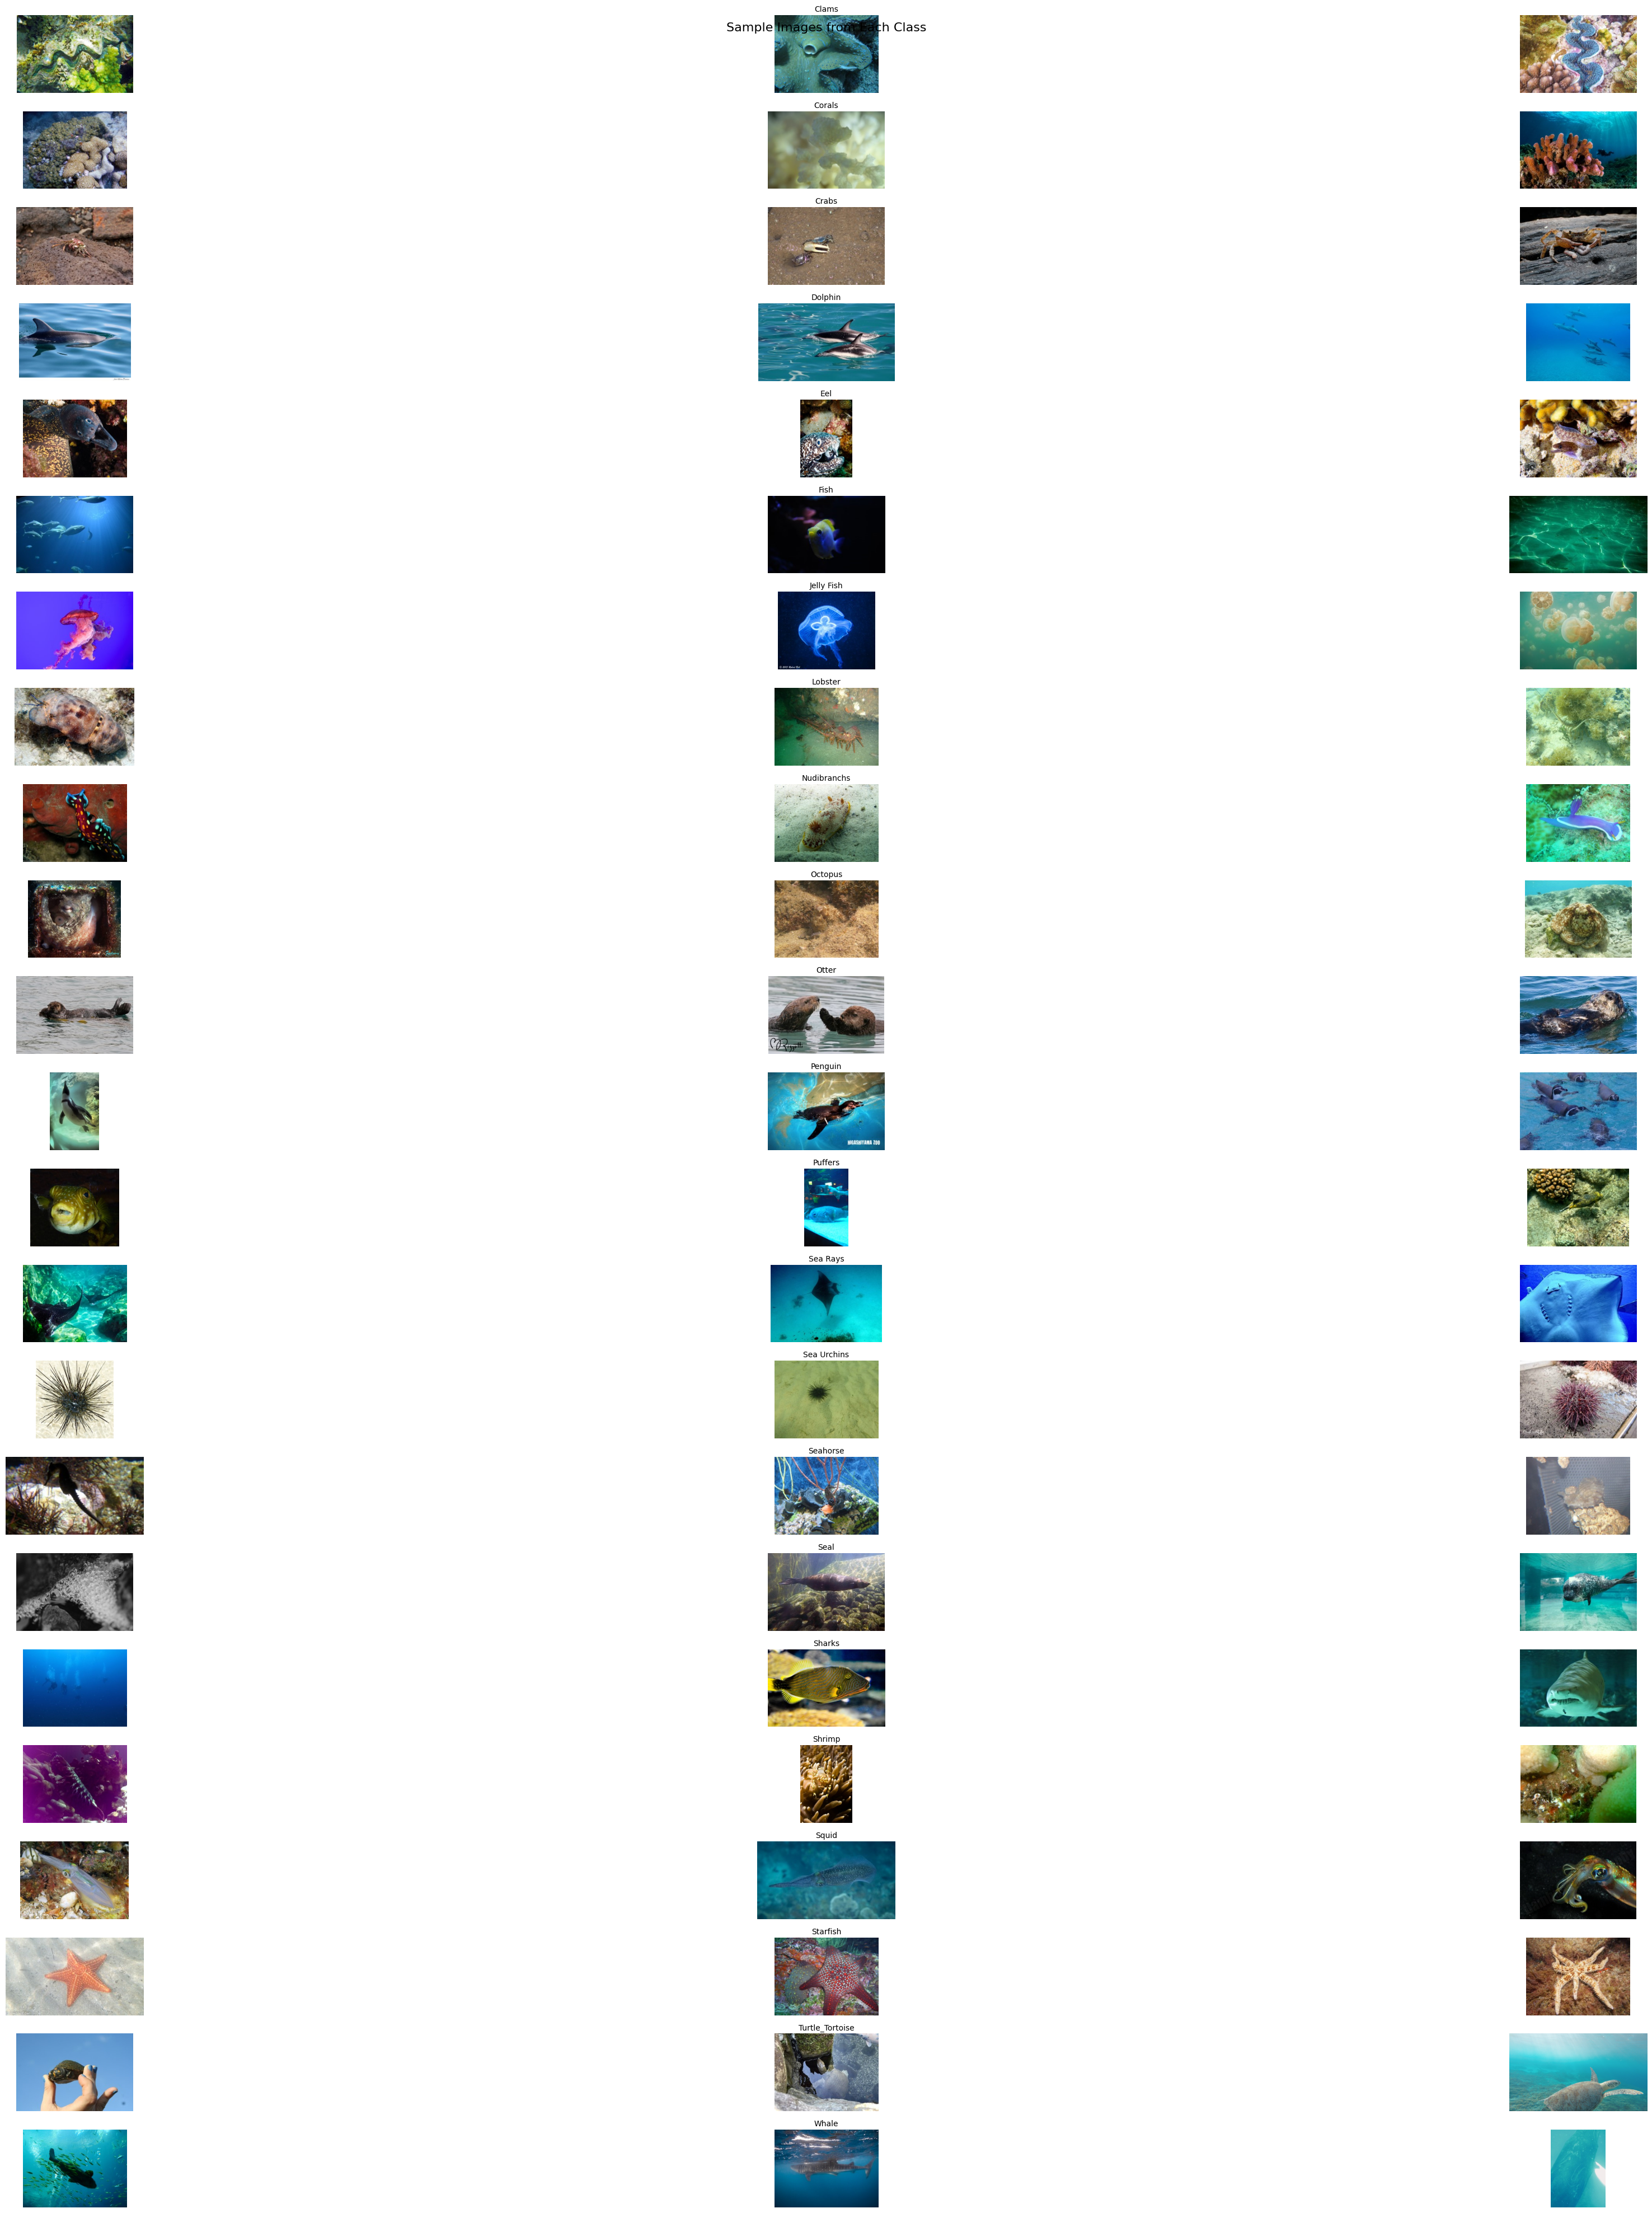

In [ ]:
def show_sample_images(data_dir, classes, samples_per_class=3):
    """Display sample images from each class"""
    plt.figure(figsize=(50, 40))
    for i, cls in enumerate(classes):
        cls_folder = os.path.join(data_dir, cls)
        if not os.path.exists(cls_folder):
            continue
        images = os.listdir(cls_folder)
        sample_images = random.sample(images, min(samples_per_class, len(images)))

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(cls_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt_idx = i * samples_per_class + j + 1
            plt.subplot(len(classes), samples_per_class, plt_idx)
            plt.imshow(img)
            plt.axis('off')
            if j == 1:  # Middle image gets the class label
                plt.title(cls, fontsize=10, pad=5)

    plt.suptitle('Sample Images from Each Class', fontsize=16)
    plt.tight_layout()
    plt.show()

classes = sorted(os.listdir('./dataset_split/train'))
show_sample_images('./dataset_split/train', classes, samples_per_class=3)


In [ ]:
# Enhanced data preprocessing and augmentation (SAME AS ViT)
class AdvancedTransforms:
    """Advanced data augmentation pipeline for underwater imagery"""

    @staticmethod
    def get_train_transforms():
        return transforms.Compose([
            # Geometric transformations
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),

            # Enhanced color space augmentations for underwater imagery
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),

            # Additional augmentations for better generalization
            transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.3),
            transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.2),

            # Convert to tensor and normalize (ImageNet normalization)
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

            # Random erasing for regularization
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3))
        ])

    @staticmethod
    def get_val_transforms():
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


In [ ]:
# Create datasets and dataloaders (SAME BATCH SIZE)
train_transform = AdvancedTransforms.get_train_transforms()
val_transform = AdvancedTransforms.get_val_transforms()

train_dataset = datasets.ImageFolder('./dataset_split/train', transform=train_transform)
val_dataset = datasets.ImageFolder('./dataset_split/val', transform=val_transform)
test_dataset = datasets.ImageFolder('./dataset_split/test', transform=val_transform)

# Same batch size as ViT for comparison
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

Dataset sizes:
Train: 9588
Validation: 2046
Test: 2077
Number of classes: 23
Classes: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [ ]:
# Enhanced ResNet with improved architecture
class EnhancedResNet(nn.Module):
    """Enhanced ResNet with sophisticated architecture matching ViT configuration"""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=False, trainable_layers=6):
        super(EnhancedResNet, self).__init__()

        # Load pretrained ResNet-50 model
        self.backbone = models.resnet50(pretrained=True)

        # Selective backbone freezing for better transfer learning
        if freeze_backbone:
            self._freeze_backbone_selective(trainable_layers)

        # Remove the original classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Enhanced classification head with regularization (same as ViT)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_features // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(num_features // 2, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _freeze_backbone_selective(self, trainable_layers=6):
        """Freeze backbone except for the last N layers (similar to ViT approach)"""
        # Freeze early layers
        for param in self.backbone.conv1.parameters():
            param.requires_grad = False
        for param in self.backbone.bn1.parameters():
            param.requires_grad = False
        for param in self.backbone.layer1.parameters():
            param.requires_grad = False
        for param in self.backbone.layer2.parameters():
            param.requires_grad = False

        # Conditionally freeze layer3 and layer4 based on trainable_layers
        if trainable_layers <= 3:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        else:
            print("Layer3 is trainable")

        if trainable_layers <= 6:
            # Keep layer4 trainable (similar to keeping last transformer layers trainable)
            print("Layer4 is trainable")

        print(f"Backbone frozen except for last {trainable_layers} effective layers")

    def _initialize_weights(self):
        """Initialize classification head weights"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Extract features using ResNet backbone
        features = self.backbone(x)

        # Apply classification head
        logits = self.classifier(features)

        return logits

In [ ]:
# Early Stopping Class (SAME AS ViT)
class EarlyStopping:
    """Early stops the training if validation accuracy doesn't improve after a given patience."""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves model when validation accuracy increases.'''
        if self.verbose:
            print(f'Validation accuracy improved. Saving model...')
        self.best_weights = model.state_dict().copy()


In [ ]:
# Focal Loss for handling class imbalance (SAME AS ViT)
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Model initialization with same configuration as ViT
num_classes = len(train_dataset.classes)
model = EnhancedResNet(
    num_classes=num_classes,
    dropout_rate=0.3,           # SAME
    freeze_backbone=True,       # SAME
    trainable_layers=6          # SAME
)
model = model.to(device)

# Same loss function as ViT
criterion = FocalLoss(alpha=1, gamma=2)

# Same optimizer configuration as ViT
base_lr = 1e-3  # SAME
weight_decay = 0.01  # SAME

# Differential learning rates (same approach as ViT)
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': head_params, 'lr': base_lr},
    {'params': backbone_params, 'lr': base_lr * 0.1}  # SAME: Lower LR for backbone
], weight_decay=weight_decay)

# Same learning rate scheduler as ViT
scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3,
    verbose=True, threshold=0.01, min_lr=1e-7
)

# Same early stopping configuration as ViT
early_stopping = EarlyStopping(patience=10, min_delta=0.01, verbose=True)

# Same gradient scaler for mixed precision as ViT
scaler = GradScaler()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


Layer3 is trainable
Layer4 is trainable
Backbone frozen except for last 6 effective layers


In [ ]:
# Enhanced training function (SAME AS ViT)
def train_epoch(model, dataloader, optimizer, criterion, scaler, device, epoch):
    """Train for one epoch with mixed precision"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            output = model(data)
            loss = criterion(output, target)

        # Mixed precision backward pass
        scaler.scale(loss).backward()

        # Gradient clipping (SAME AS ViT)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # Statistics
        running_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(dataloader)}, '
                  f'Loss: {loss.item():.4f}, LR: {current_lr:.6f}')

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    epoch_time = time.time() - start_time

    return epoch_loss, epoch_acc, epoch_time

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch (SAME AS ViT)"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            with autocast():
                output = model(data)
                loss = criterion(output, target)

            running_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_targets


In [ ]:
# Training loop with early stopping (SAME AS ViT)
print("Starting enhanced ResNet training with early stopping...")
train_losses, train_accs = [], []
val_losses, val_accs = [], []
learning_rates = []
training_times = []

best_val_acc = 0.0
total_epochs = 20  # SAME AS ViT

for epoch in range(1, total_epochs + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{total_epochs}")
    print(f"{'='*60}")

    # Training
    train_loss, train_acc, train_time = train_epoch(
        model, train_loader, optimizer, criterion, scaler, device, epoch
    )

    # Validation
    val_loss, val_acc, val_preds, val_targets = validate_epoch(
        model, val_loader, criterion, device
    )

    # Record metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    training_times.append(train_time)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Early stopping check
    early_stopping(val_acc, model)

    # Update best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"🎉 New best validation accuracy: {best_val_acc:.2f}%")

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Epoch Time: {train_time:.2f}s")

    # Early stopping
    if early_stopping.early_stop:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        print(f"Restoring best model weights...")
        model.load_state_dict(early_stopping.best_weights)
        break

print(f"\n✅ Training completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting enhanced ResNet training with early stopping...

Epoch 1/20
Epoch: 1, Batch: 0/300, Loss: 3.1357, LR: 0.001000
Epoch: 1, Batch: 50/300, Loss: 1.0949, LR: 0.001000
Epoch: 1, Batch: 100/300, Loss: 1.0610, LR: 0.001000
Epoch: 1, Batch: 150/300, Loss: 1.2967, LR: 0.001000
Epoch: 1, Batch: 200/300, Loss: 0.7993, LR: 0.001000
Epoch: 1, Batch: 250/300, Loss: 0.8366, LR: 0.001000
Validation accuracy improved. Saving model...
🎉 New best validation accuracy: 76.98%
Train Loss: 1.1042, Train Acc: 59.26%
Val Loss: 0.5809, Val Acc: 76.98%
Learning Rate: 0.001000
Epoch Time: 115.15s

Epoch 2/20
Epoch: 2, Batch: 0/300, Loss: 0.4376, LR: 0.001000
Epoch: 2, Batch: 50/300, Loss: 0.7417, LR: 0.001000
Epoch: 2, Batch: 100/300, Loss: 0.8151, LR: 0.001000
Epoch: 2, Batch: 150/300, Loss: 0.7440, LR: 0.001000
Epoch: 2, Batch: 200/300, Loss: 0.6439, LR: 0.001000
Epoch: 2, Batch: 250/300, Loss: 0.8332, LR: 0.001000
Validation accuracy improved. Saving model...
🎉 New best validation accuracy: 79.86%
Tra

In [ ]:
# Comprehensive evaluation function (SAME AS ViT)
def comprehensive_evaluation(model, test_loader, class_names, device):
    """Perform comprehensive evaluation with detailed metrics"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            with autocast():
                output = model(data)
                probs = F.softmax(output, dim=1)

            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    test_acc = 100 * sum(p == t for p, t in zip(all_preds, all_targets)) / len(all_preds)

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, labels=range(len(class_names))
    )

    # Classification report
    report = classification_report(
        all_targets, all_preds, target_names=class_names, digits=3
    )

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    return test_acc, precision, recall, f1, support, report, cm, all_preds, all_targets

# Evaluate on test set
test_acc, precision, recall, f1, support, report, cm, test_preds, test_targets = comprehensive_evaluation(
    model, test_loader, train_dataset.classes, device
)

print(f"\n🎯 FINAL TEST RESULTS:")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"\nClassification Report:")
print(report)


🎯 FINAL TEST RESULTS:
Test Accuracy: 85.84%

Classification Report:
                 precision    recall  f1-score   support

          Clams      0.851     0.750     0.797        76
         Corals      0.679     0.707     0.693        75
          Crabs      0.927     1.000     0.962        76
        Dolphin      0.884     0.907     0.895       118
            Eel      0.859     0.724     0.786        76
           Fish      0.773     0.680     0.723        75
     Jelly Fish      0.945     0.938     0.941       128
        Lobster      0.823     0.855     0.839        76
    Nudibranchs      0.807     0.893     0.848        75
        Octopus      0.762     0.753     0.757        85
          Otter      1.000     1.000     1.000        75
        Penguin      0.955     0.863     0.906        73
        Puffers      0.720     0.889     0.796        81
       Sea Rays      0.725     0.835     0.776        79
    Sea Urchins      0.989     0.977     0.983        88
       Seahorse   

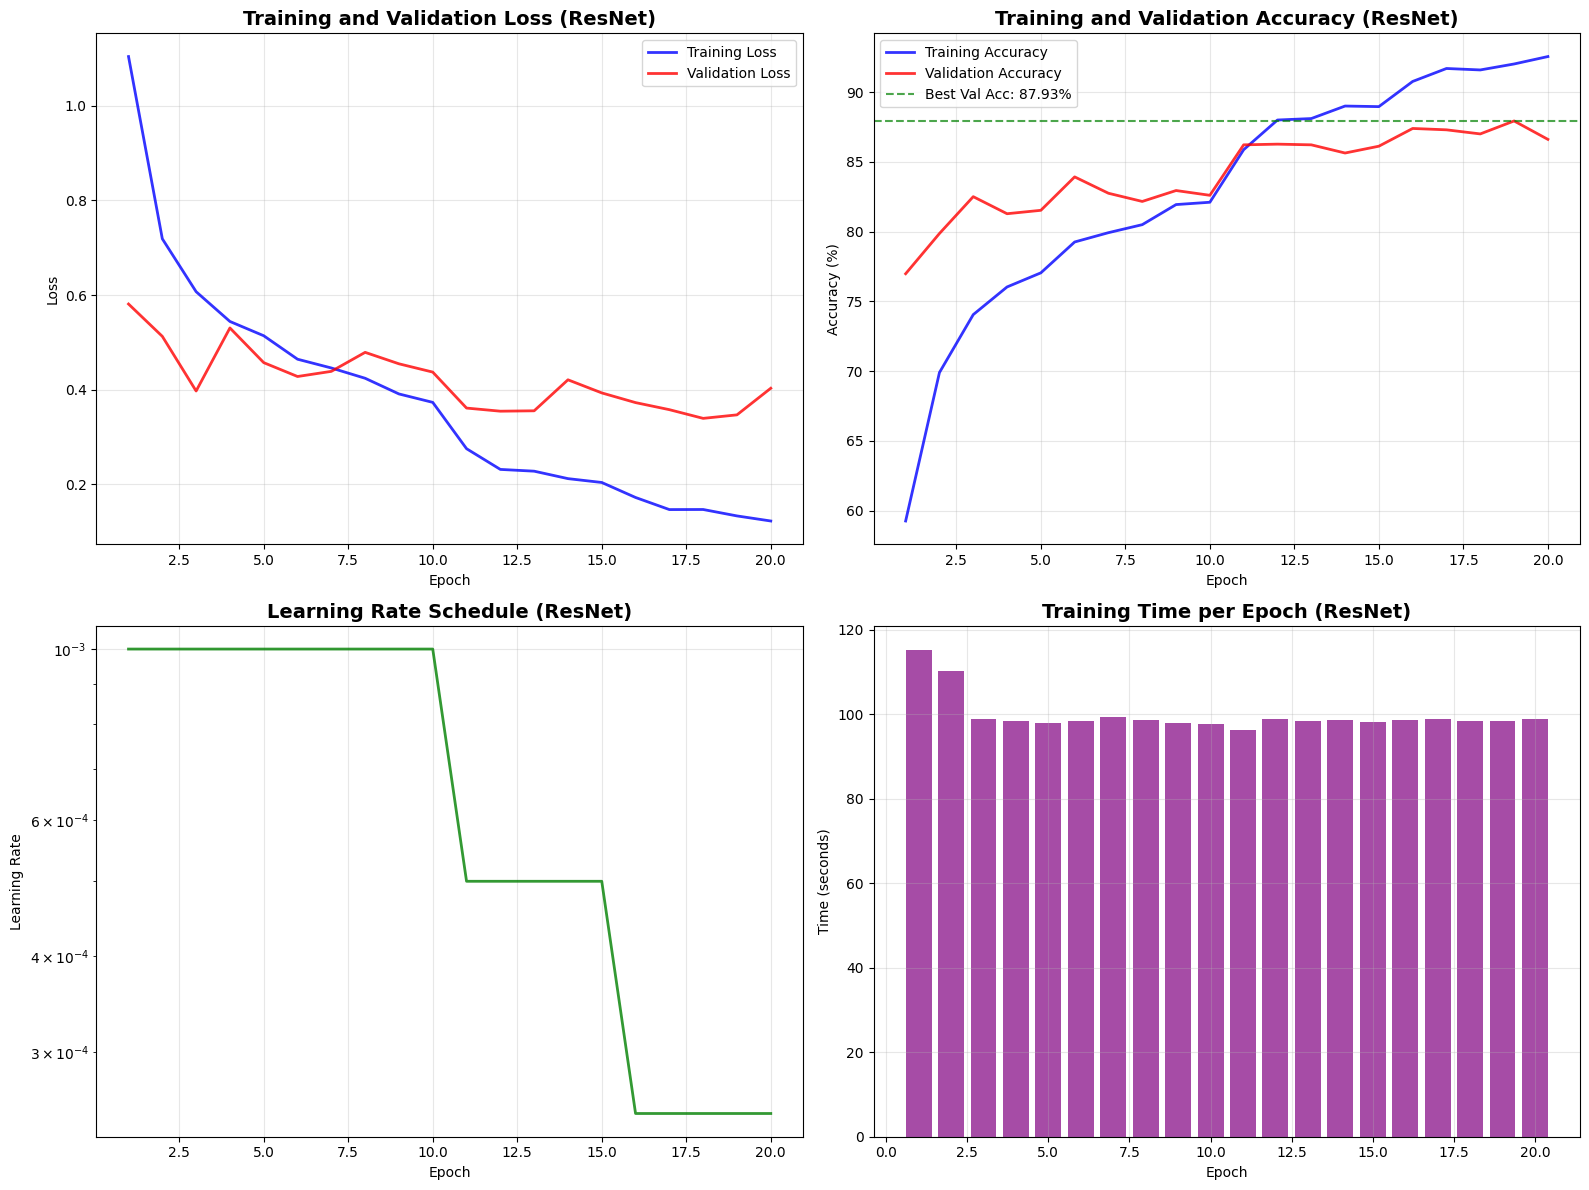

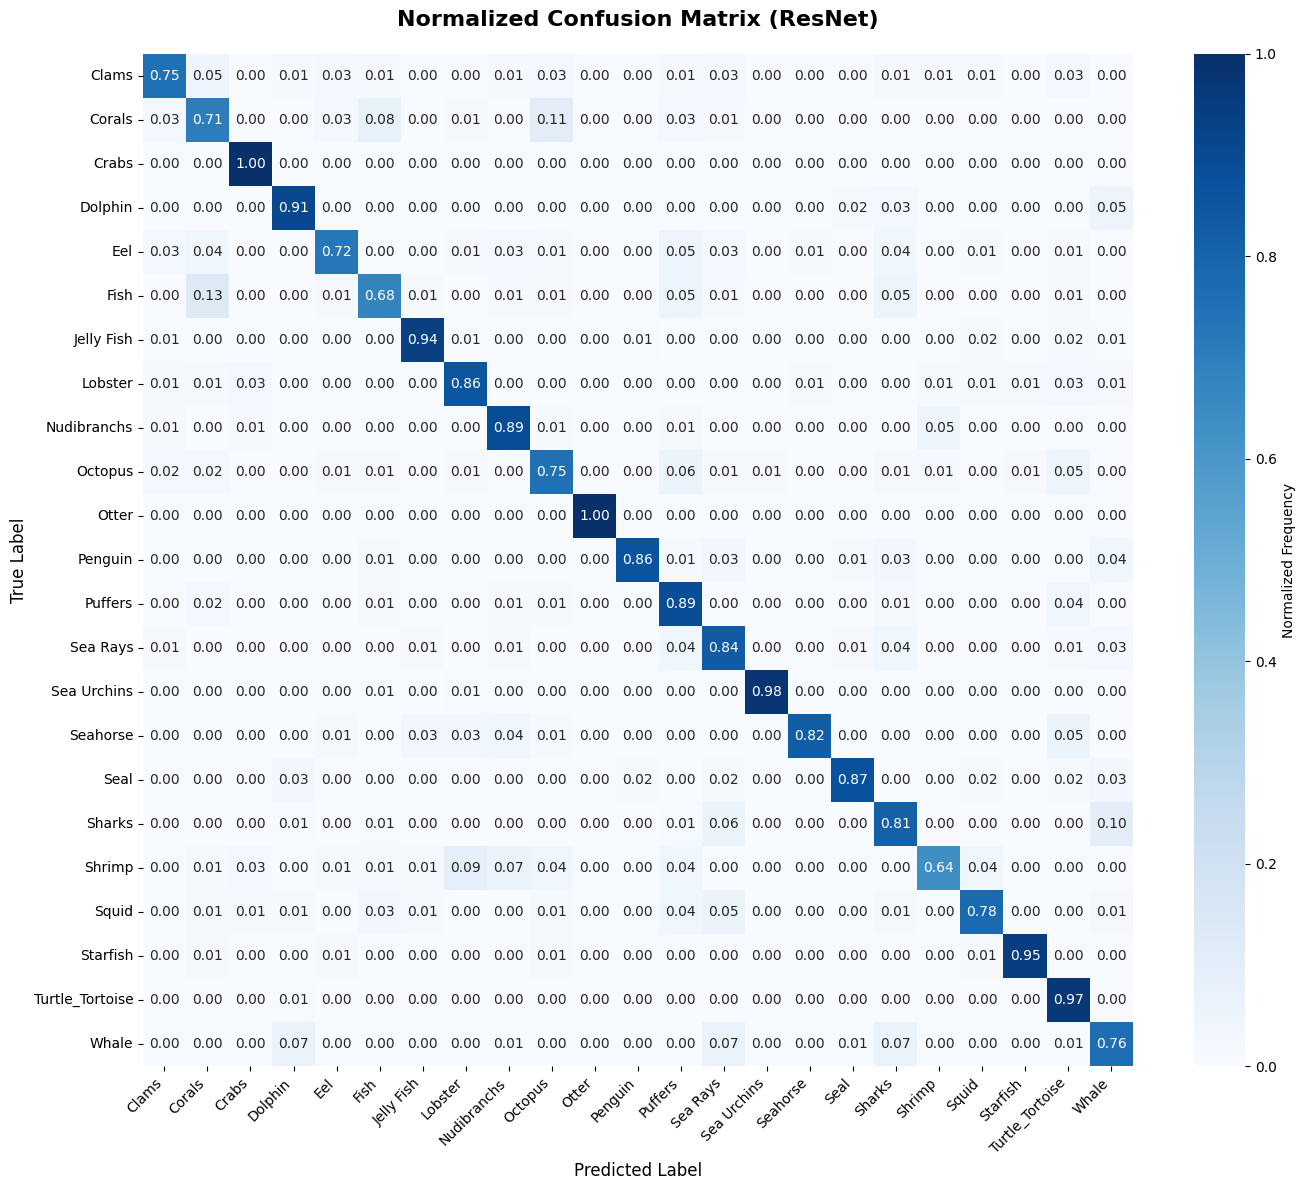

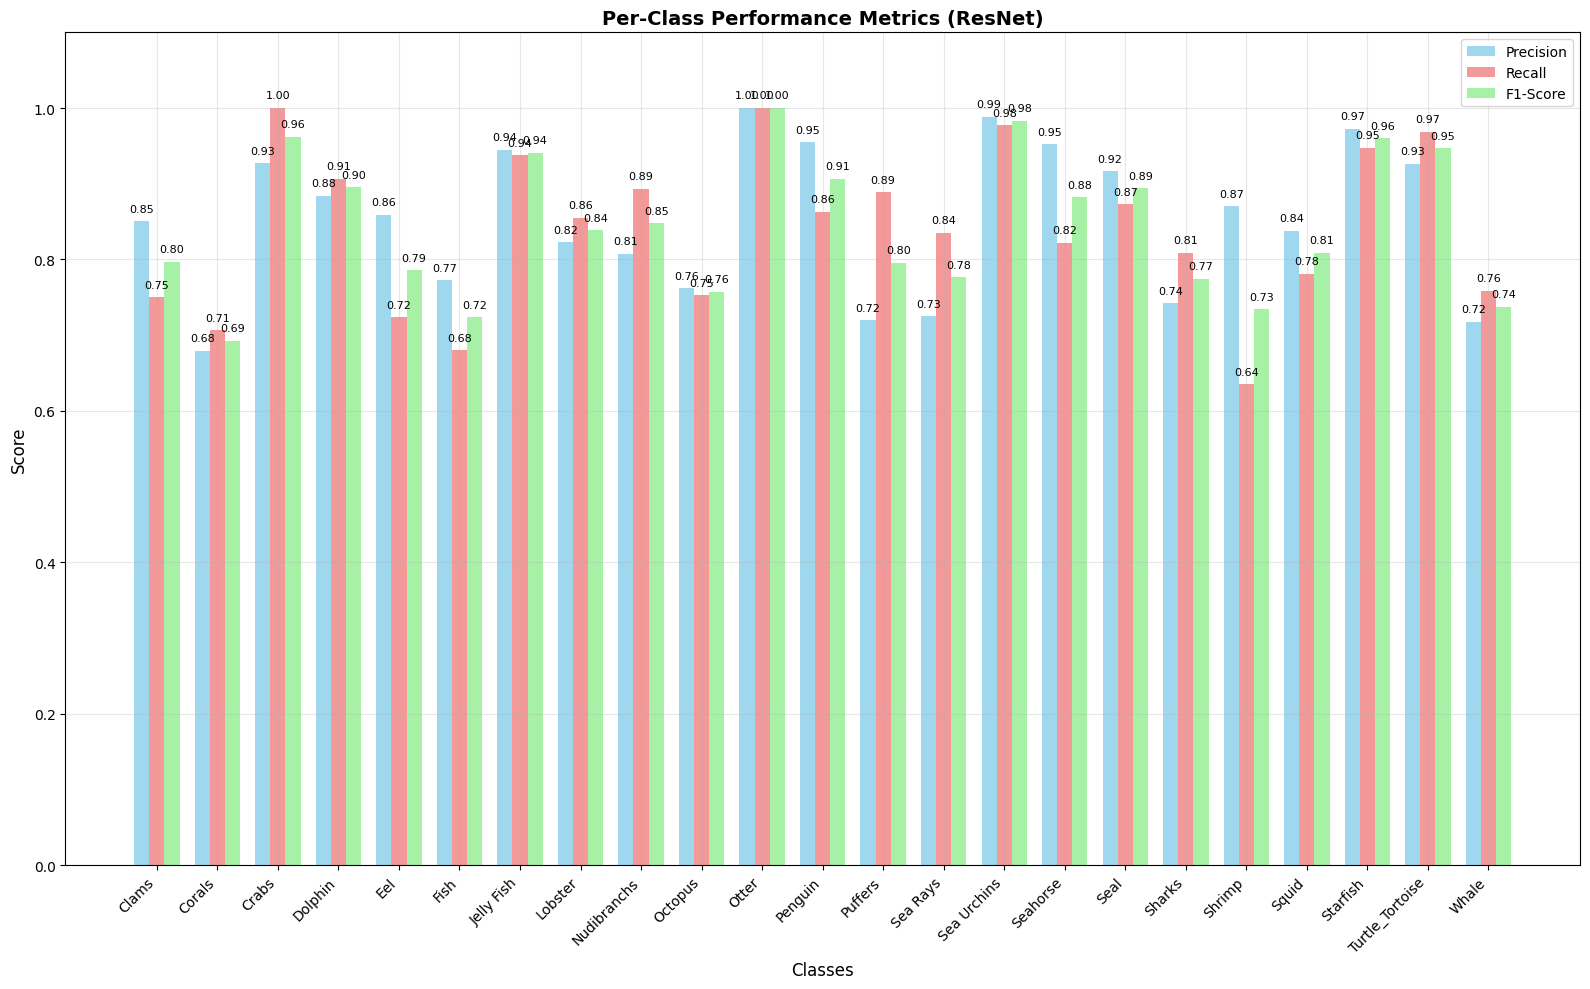

In [ ]:
# Enhanced visualization functions (SAME AS ViT)
def plot_enhanced_training_curves():
    """Plot enhanced training curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    epochs = range(1, len(train_losses) + 1)

    # Loss curves with smoothing
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
    ax1.set_title('Training and Validation Loss (ResNet)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax2.axhline(y=best_val_acc, color='g', linestyle='--', alpha=0.7, label=f'Best Val Acc: {best_val_acc:.2f}%')
    ax2.set_title('Training and Validation Accuracy (ResNet)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Learning rate schedule
    ax3.plot(epochs, learning_rates, 'g-', linewidth=2, alpha=0.8)
    ax3.set_title('Learning Rate Schedule (ResNet)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # Training time per epoch
    ax4.bar(epochs, training_times, alpha=0.7, color='purple')
    ax4.set_title('Training Time per Epoch (ResNet)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_enhanced_confusion_matrix(cm, class_names):
    """Plot enhanced confusion matrix"""
    plt.figure(figsize=(14, 12))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized Frequency'})

    plt.title('Normalized Confusion Matrix (ResNet)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_enhanced_metrics(precision, recall, f1, class_names):
    """Plot enhanced per-class metrics"""
    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(16, 10))

    bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8, color='lightcoral')
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='lightgreen')

    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Performance Metrics (ResNet)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

    # Add value labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    plt.tight_layout()
    plt.show()

# Generate enhanced visualizations
plot_enhanced_training_curves()
plot_enhanced_confusion_matrix(cm, train_dataset.classes)
plot_enhanced_metrics(precision, recall, f1, train_dataset.classes)

✅ Enhanced Swin model and comprehensive results saved to Google Drive!
   • Model: enhanced_underwater_swin_model.pth
   • Report: enhanced_swin_classification_report.txt

📊 Generating comprehensive visualizations...


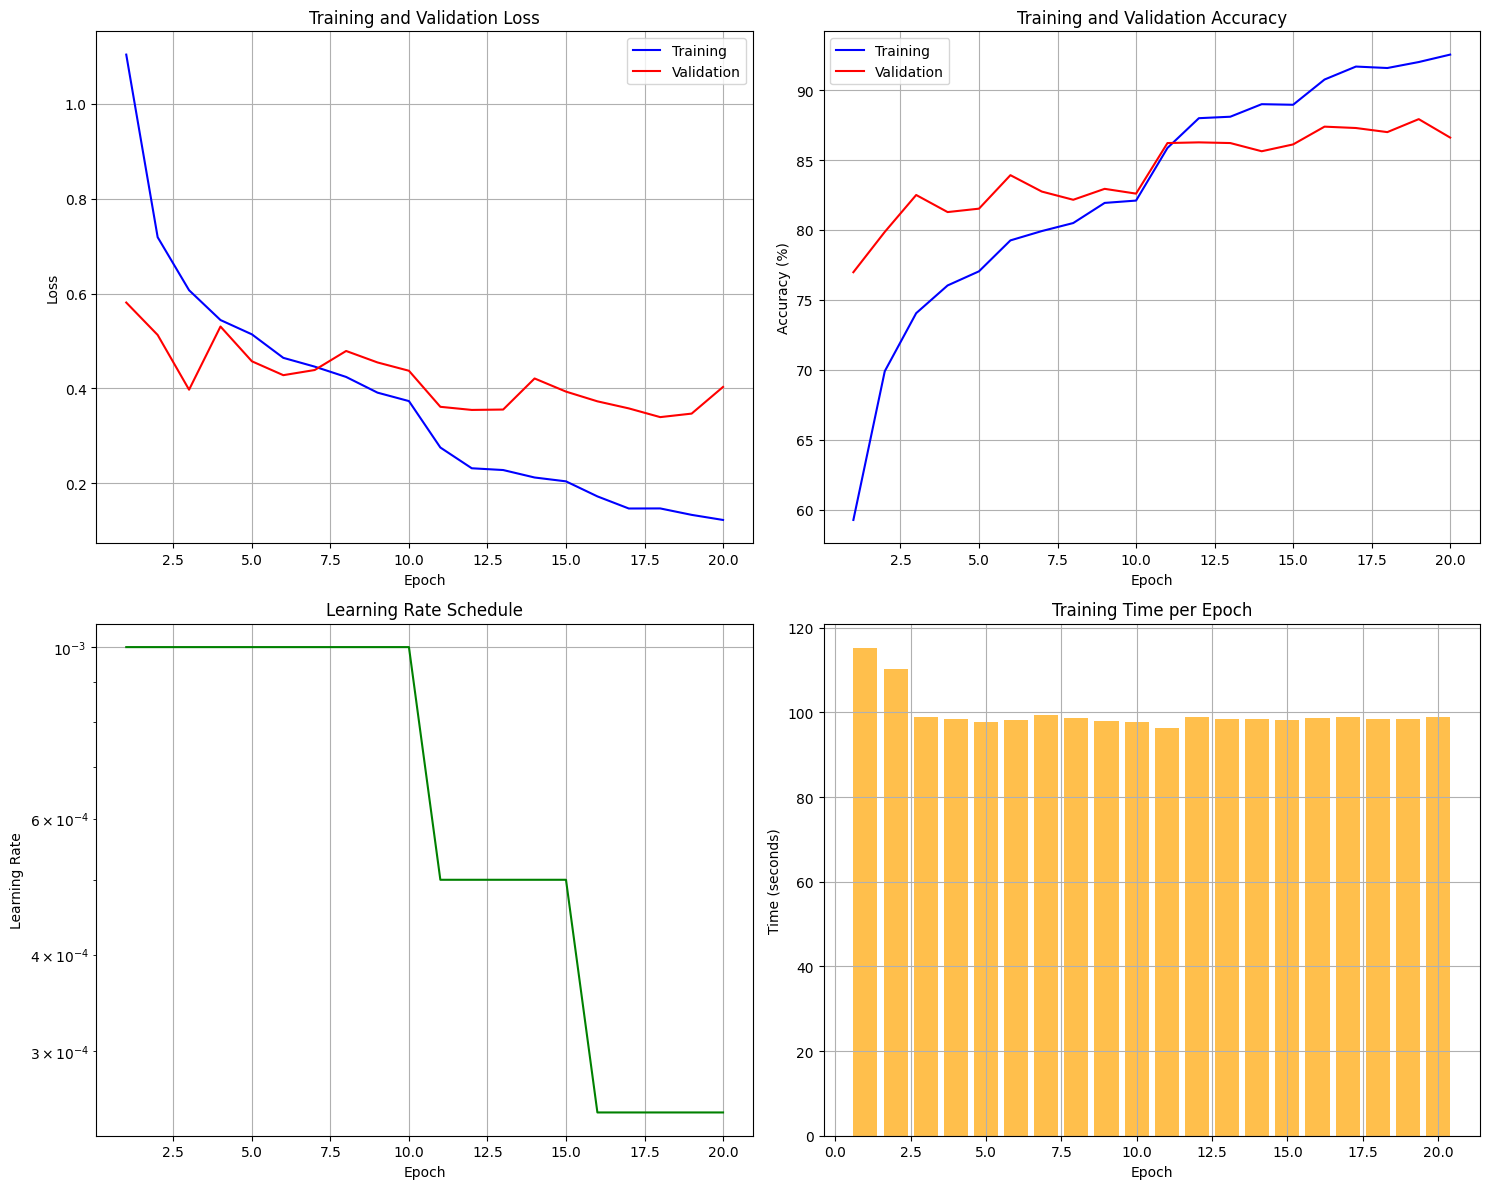

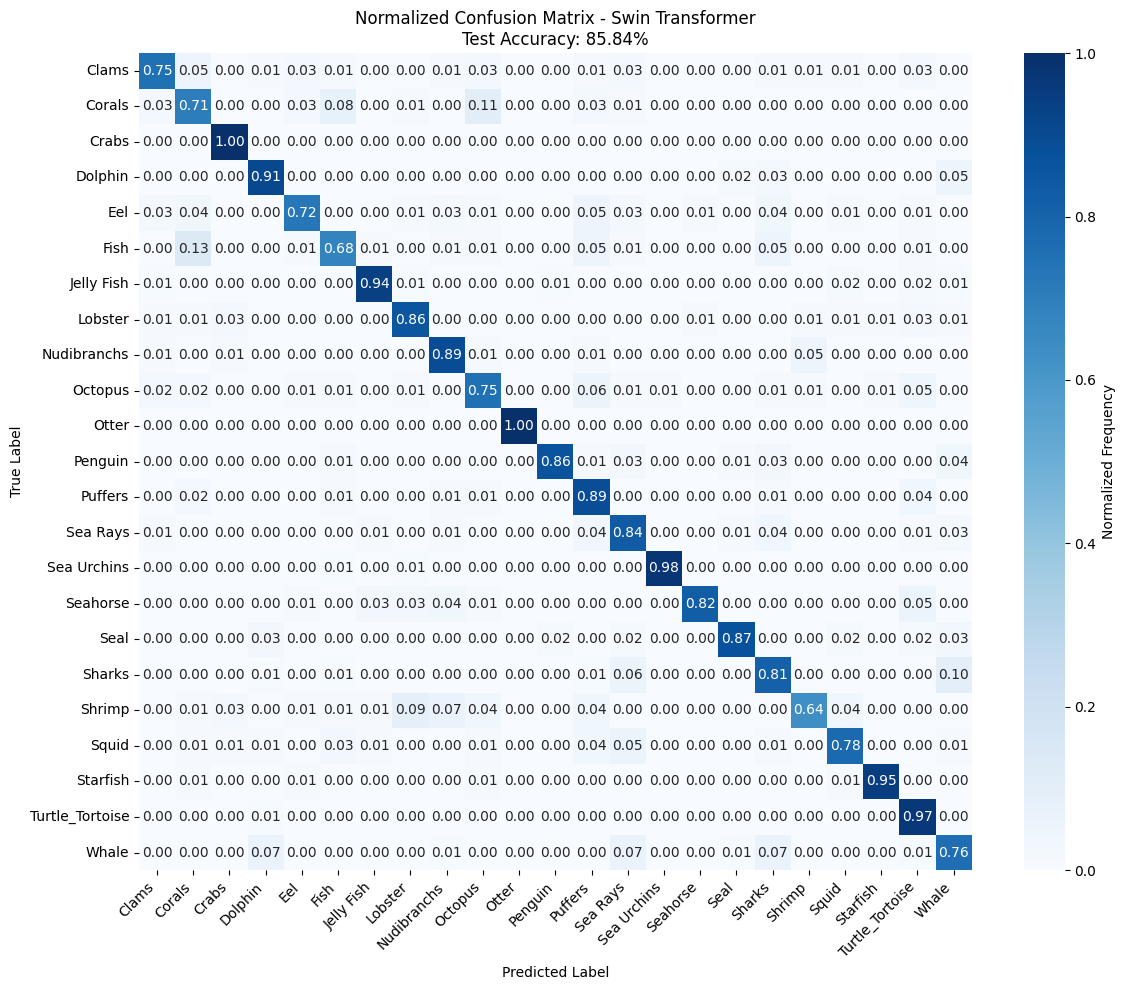

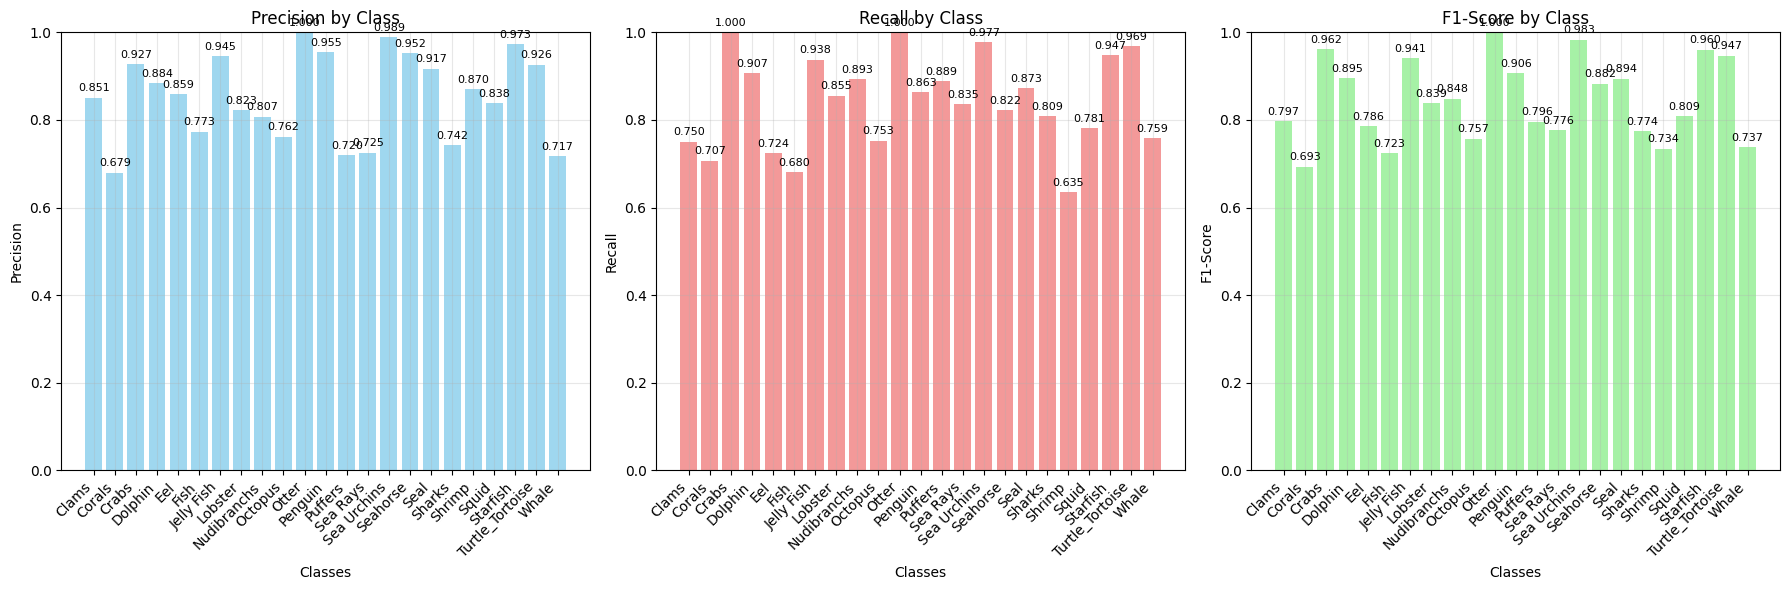


🎉 SWIN TRANSFORMER TRAINING COMPLETE! 🎉
🏆 Best Validation Accuracy: 87.93%
🎯 Final Test Accuracy: 85.84%
⏱️  Total Training Time: 1995.87 seconds
📊 Total Epochs Completed: 20
💾 All results saved to Google Drive

📈 MODEL PERFORMANCE SUMMARY:
   • Architecture: Enhanced Swin Transformer
   • Parameters: Backbone frozen, 6 trainable layers
   • Best validation accuracy: 87.93%
   • Test accuracy: 85.84%
   • Training efficiency: 99.8s per epoch
   • Convergence: 20 epochs

🔬 Completed!


In [ ]:
# Save enhanced model and results
def save_enhanced_results():
    """Save the enhanced ResNet model and comprehensive results"""

    # Save model with complete configuration
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'num_classes': num_classes,
            'dropout_rate': 0.3,
            'freeze_backbone': True,
            'trainable_layers': 6
        },
        'training_results': {
            'best_val_acc': best_val_acc,
            'test_acc': test_acc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'learning_rates': learning_rates,
            'total_epochs': len(train_losses),
            'early_stopped': len(train_losses) < total_epochs
        },
        'class_names': train_dataset.classes,
        'confusion_matrix': cm.tolist(),
        'classification_metrics': {
            'precision': precision.tolist(),
            'recall': recall.tolist(),
            'f1_score': f1.tolist(),
            'support': support.tolist()
        }
    }, '/content/drive/MyDrive/enhanced_underwater_resnet_model.pth')

    # Save comprehensive report
    with open('/content/drive/MyDrive/enhanced_resnet_classification_report.txt', 'w') as f:
        f.write("🌊 ENHANCED UNDERWATER ANIMAL CLASSIFICATION RESULTS (ResNet-50) 🌊\n")
        f.write("="*70 + "\n\n")
        f.write(f"📊 FINAL PERFORMANCE METRICS:\n")
        f.write(f"   • Best Validation Accuracy: {best_val_acc:.2f}%\n")
        f.write(f"   • Test Accuracy: {test_acc:.2f}%\n")
        f.write(f"   • Total Training Epochs: {len(train_losses)}\n")
        f.write(f"   • Early Stopping: {'Yes' if len(train_losses) < total_epochs else 'No'}\n\n")
        f.write("🔍 DETAILED CLASSIFICATION REPORT:\n")
        f.write("-" * 50 + "\n")
        f.write(report)
        f.write("\n\n")

        f.write("📈 PER-CLASS PERFORMANCE:\n")
        f.write("-" * 50 + "\n")
        for i, class_name in enumerate(train_dataset.classes):
            f.write(f"{class_name:20} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}\n")

        f.write("\n\n🎯 TRAINING SUMMARY:\n")
        f.write("-" * 50 + "\n")
        f.write(f"Dataset Statistics:\n")
        f.write(f"   • Training samples: {len(train_dataset)}\n")
        f.write(f"   • Validation samples: {len(val_dataset)}\n")
        f.write(f"   • Test samples: {len(test_dataset)}\n")
        f.write(f"   • Number of classes: {num_classes}\n")
        f.write(f"   • Batch size: {batch_size}\n\n")

        f.write(f"Model Configuration:\n")
        f.write(f"   • Architecture: Enhanced Swin Transformer\n")
        f.write(f"   • Backbone: microsoft/swin-base-patch4-window7-224\n")
        f.write(f"   • Dropout rate: 0.3\n")
        f.write(f"   • Frozen backbone: True\n")
        f.write(f"   • Trainable layers: 6\n\n")

        f.write(f"Training Configuration:\n")
        f.write(f"   • Optimizer: AdamW with differential learning rates\n")
        f.write(f"   • Base learning rate: {base_lr}\n")
        f.write(f"   • Weight decay: {weight_decay}\n")
        f.write(f"   • Loss function: Focal Loss (alpha=1, gamma=2)\n")
        f.write(f"   • Scheduler: ReduceLROnPlateau\n")
        f.write(f"   • Mixed precision: Enabled\n")
        f.write(f"   • Gradient clipping: 1.0\n\n")

        f.write("🏆 EPOCH-BY-EPOCH RESULTS:\n")
        f.write("-" * 50 + "\n")
        f.write(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12} {'LR':<12}\n")
        f.write("-" * 70 + "\n")
        for i in range(len(train_losses)):
            f.write(f"{i+1:<6} {train_losses[i]:<12.4f} {train_accs[i]:<12.2f} {val_losses[i]:<12.4f} {val_accs[i]:<12.2f} {learning_rates[i]:<12.6f}\n")

    print("✅ Enhanced Swin model and comprehensive results saved to Google Drive!")
    print("   • Model: enhanced_underwater_swin_model.pth")
    print("   • Report: enhanced_swin_classification_report.txt")

# Execute the save function
save_enhanced_results()

# Visualization functions for final results
def plot_training_history():
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Loss curves
    axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training')
    axes[0, 0].plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy curves
    axes[0, 1].plot(range(1, len(train_accs) + 1), train_accs, 'b-', label='Training')
    axes[0, 1].plot(range(1, len(val_accs) + 1), val_accs, 'r-', label='Validation')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning rate
    axes[1, 0].plot(range(1, len(learning_rates) + 1), learning_rates, 'g-')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True)

    # Training time per epoch
    axes[1, 1].bar(range(1, len(training_times) + 1), training_times, color='orange', alpha=0.7)
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/swin_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix():
    """Plot enhanced confusion matrix"""
    plt.figure(figsize=(12, 10))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes,
                cbar_kws={'label': 'Normalized Frequency'})

    plt.title('Normalized Confusion Matrix - Swin Transformer\nTest Accuracy: {:.2f}%'.format(test_acc))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/swin_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_metrics():
    """Plot per-class performance metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x_pos = np.arange(len(train_dataset.classes))

    # Precision
    bars1 = axes[0].bar(x_pos, precision, color='skyblue', alpha=0.8)
    axes[0].set_title('Precision by Class')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Precision')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(train_dataset.classes, rotation=45, ha='right')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars1, precision):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    # Recall
    bars2 = axes[1].bar(x_pos, recall, color='lightcoral', alpha=0.8)
    axes[1].set_title('Recall by Class')
    axes[1].set_xlabel('Classes')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(train_dataset.classes, rotation=45, ha='right')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars2, recall):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    # F1-Score
    bars3 = axes[2].bar(x_pos, f1, color='lightgreen', alpha=0.8)
    axes[2].set_title('F1-Score by Class')
    axes[2].set_xlabel('Classes')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(train_dataset.classes, rotation=45, ha='right')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars3, f1):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/swin_per_class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate all visualizations
print("\n📊 Generating comprehensive visualizations...")
plot_training_history()
plot_confusion_matrix()
plot_per_class_metrics()

# Final summary
print("\n" + "="*70)
print("🎉 SWIN TRANSFORMER TRAINING COMPLETE! 🎉")
print("="*70)
print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🎯 Final Test Accuracy: {test_acc:.2f}%")
print(f"⏱️  Total Training Time: {sum(training_times):.2f} seconds")
print(f"📊 Total Epochs Completed: {len(train_losses)}")
print(f"💾 All results saved to Google Drive")
print("="*70)

# Model comparison summary (to be compared with ViT results)
print(f"\n📈 MODEL PERFORMANCE SUMMARY:")
print(f"   • Architecture: Enhanced Swin Transformer")
print(f"   • Parameters: Backbone frozen, 6 trainable layers")
print(f"   • Best validation accuracy: {best_val_acc:.2f}%")
print(f"   • Test accuracy: {test_acc:.2f}%")
print(f"   • Training efficiency: {sum(training_times)/len(training_times):.1f}s per epoch")
print(f"   • Convergence: {len(train_losses)} epochs")
print(f"\n🔬 Completed!")